In [1]:
#!pip install matplotlib
#!pip install tensorflow-datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Step 1: Load the data
(ds_train, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

In [4]:
# Step 2: Preprocess the data
IMG_SIZE = 224  # MobileNet standard input size
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1] range
    return image, label

ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

<Figure size 1000x1000 with 0 Axes>

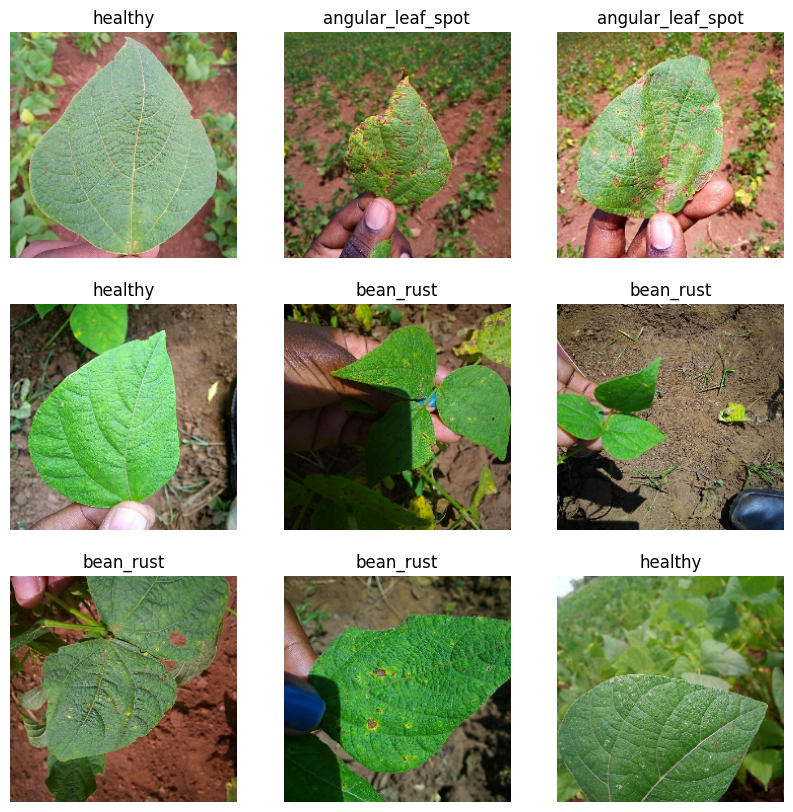

In [5]:

# Step 3: Visualize the data
class_names = ds_info.features['label'].names
plt.figure(figsize=(10, 10))
# Unbatch the dataset for visualization and shuffle it
ds_train_unbatched = ds_train.unbatch().shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train_unbatched.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.show()

In [6]:

# Step 4: Load MobileNet for Transfer Learning
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Apply Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 821ms/step - accuracy: 0.6244 - loss: 0.8216 - val_accuracy: 0.8750 - val_loss: 0.3405
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 775ms/step - accuracy: 0.9100 - loss: 0.2480 - val_accuracy: 0.8906 - val_loss: 0.2569
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 751ms/step - accuracy: 0.9513 - loss: 0.1559 - val_accuracy: 0.8984 - val_loss: 0.2872
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 785ms/step - accuracy: 0.9504 - loss: 0.1323 - val_accuracy: 0.8672 - val_loss: 0.3444
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 761ms/step - accuracy: 0.9723 - loss: 0.0976 - val_accuracy: 0.9062 - val_loss: 0.2376
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 796ms/step - accuracy: 0.9893 - loss: 0.0531 - val_accuracy: 0.9062 - val_loss: 0.2331
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 816ms/step - accuracy: 0.9975 - loss: 0.0382 - val_accuracy: 0.9062 - val_loss: 0.2339
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 923ms/step - accuracy: 0.9998 - loss: 0.0309 - val_accu

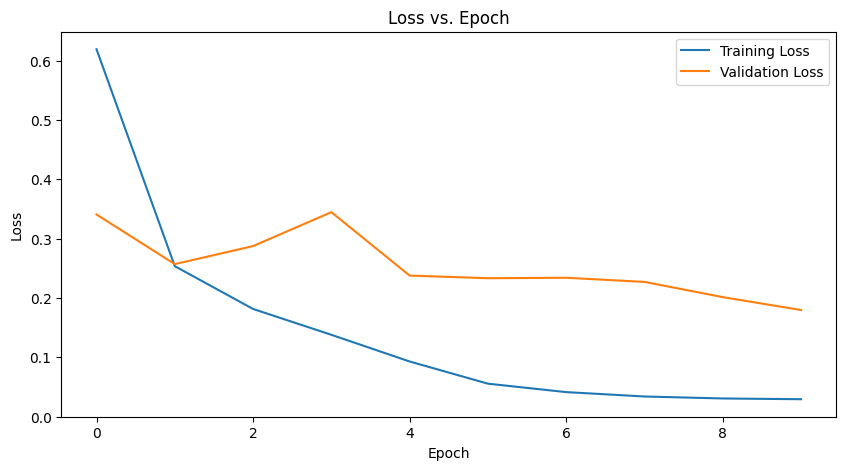

In [10]:
# Step 6: Train the Model
history = model.fit(ds_train, epochs=10, validation_data=ds_test, callbacks=[early_stopping])

# Step 7: Plot Loss vs. Epoch
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


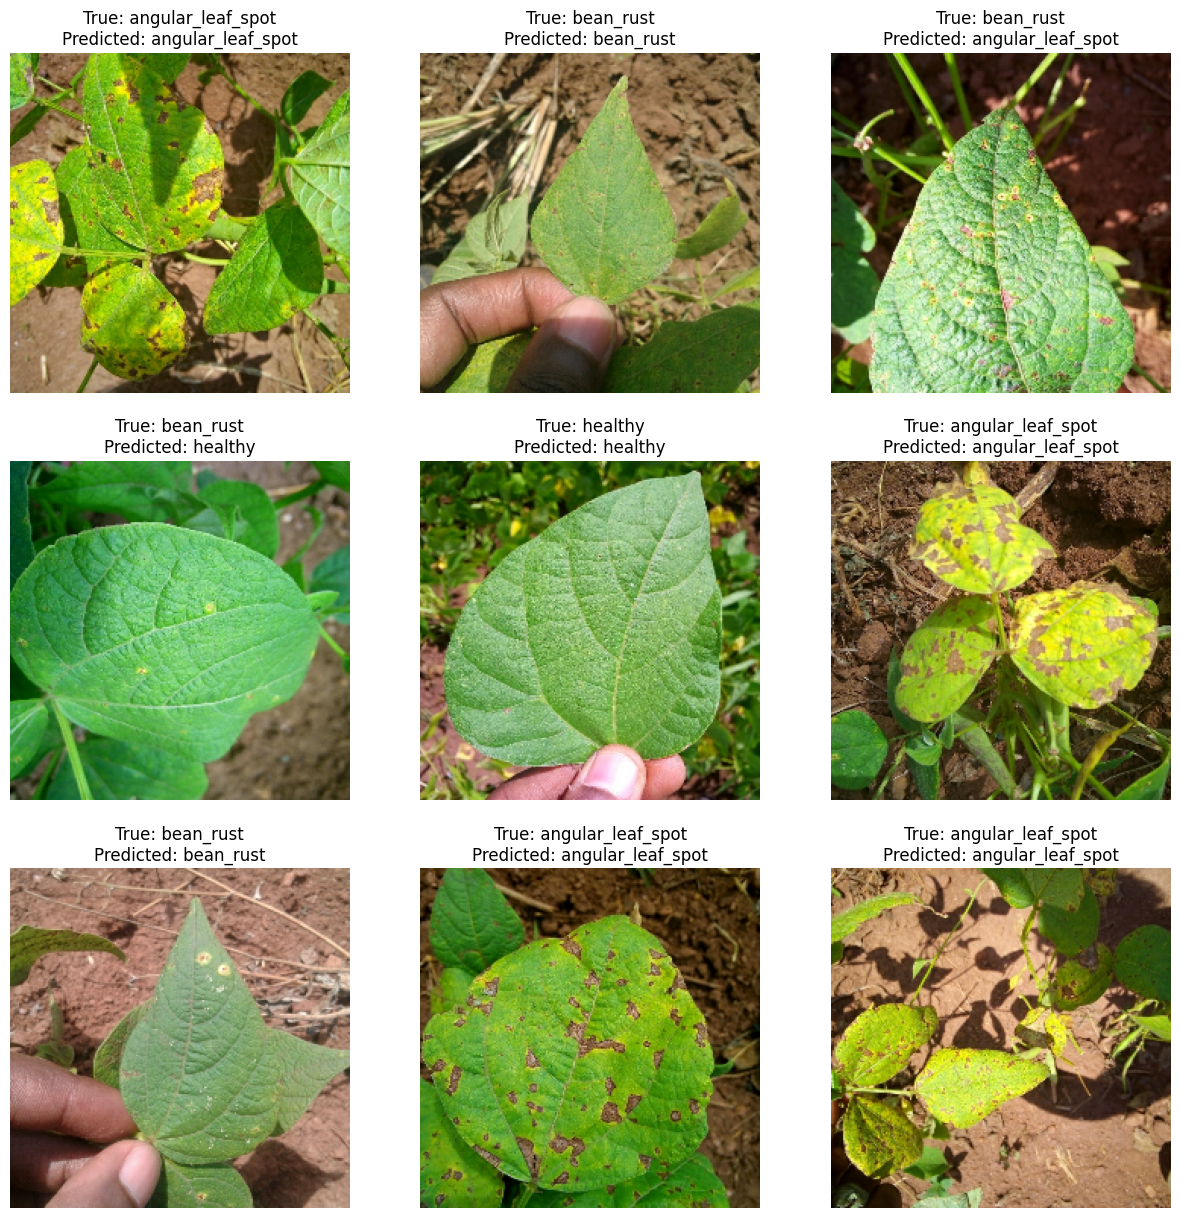

In [11]:

# Step 8: Predict on the Test Data
test_images, test_labels = next(iter(ds_test))
predictions = model.predict(test_images)

# Step 9: Visualize the Results on Test Samples
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy())
    predicted_label = class_names[tf.argmax(predictions[i])]
    true_label = class_names[test_labels[i].numpy()]
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis("off")
plt.show()

In [15]:
#Inbuilt model evaluation
# model.evaluate(test_images
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(ds_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step - accuracy: 0.9062 - loss: 0.1838
Test Loss: 0.1794814169406891
Test Accuracy: 0.9140625


In [26]:
#Evaluate with Custom Metrics
from sklearn.metrics import precision_recall_fscore_support


# Get predictions on the entire test dataset
predictions = model.predict(ds_test)

# Convert predictions to class labels (assuming softmax output)
predicted_classes = tf.argmax(predictions, axis=1).numpy()

# Extract true labels from the test dataset
true_labels = tf.concat([y for x, y in ds_test], axis=0).numpy()

# Compute precision, recall, F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_classes)

for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall:    {recall[i]:.2f}")
    print(f"  F1 Score:  {f1[i]:.2f}")



4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step
Class: angular_leaf_spot
  Precision: 0.87
  Recall:    0.95
  F1 Score:  0.91
Class: bean_rust
  Precision: 0.90
  Recall:    0.84
  F1 Score:  0.87
Class: healthy
  Precision: 0.98
  Recall:    0.95
  F1 Score:  0.96


                   precision    recall  f1-score   support

angular_leaf_spot       0.87      0.95      0.91        43
        bean_rust       0.90      0.84      0.87        43
          healthy       0.98      0.95      0.96        42

         accuracy                           0.91       128
        macro avg       0.92      0.91      0.91       128
     weighted avg       0.92      0.91      0.91       128

[[41  2  0]
 [ 6 36  1]
 [ 0  2 40]]


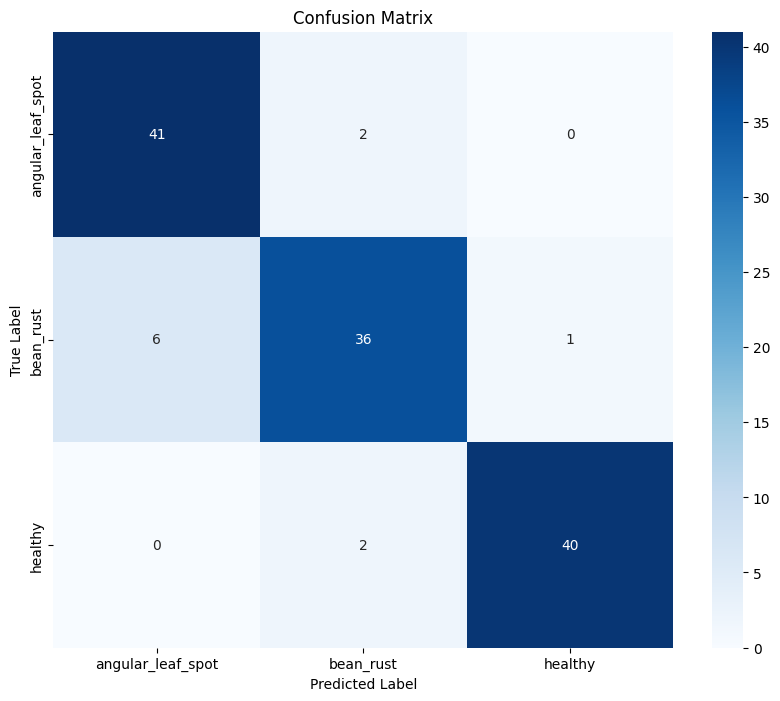

In [29]:
#Compute Metrics
#Use libraries like scikit-learn for more metrics:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print(classification_report(true_labels, predicted_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_classes)
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [30]:
model.save('C:/Users/Vignesh/Downloads/SRM/Sem/Deep Learning/mobilenetv2_beans_model.h5')

In [31]:
model.save('C:/Users/Vignesh/Downloads/SRM/Sem/Deep Learning/mobilenetv2_beans_model.keras')